In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

### Select HUB/TF2 Module to use

In [2]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
print(handle_base, pixels, FV_SIZE)

mobilenet_v2 224 1280


In [3]:
#MODULE_HANDLE ="https://tfhub.dev/google/imagenet/mobilenet_v2_100_160/classification/4"

#MODULE_HANDLE =f"https://tfhub.dev/google/imagenet/mobilenet_v2_050_96/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print(f"Using {MODULE_HANDLE} with input size {IMAGE_SIZE} and output dimension {FV_SIZE}")

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [4]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [6]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label

In [7]:
BATCH_SIZE = 32

In [8]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [9]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [10]:
do_fine_tuning = False

In [12]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3, ),
    output_shape = [FV_SIZE],
    trainable=do_fine_tuning
)

In [13]:
print(f"Building model with {MODULE_HANDLE}")
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
NUM_LAYERS = 10
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True
        
else:
    feature_extractor.trainable = False

In [16]:
if do_fine_tuning:
    model.compile(
        optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
else:
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    


In [17]:
EPOCHS = 5
hist = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches
)

Epoch 1/5
582/582 [==============================] - 532s 913ms/step - loss: 0.0497 - accuracy: 0.9832 - val_loss: 0.0395 - val_accuracy: 0.9854
Epoch 2/5
582/582 [==============================] - 688s 1s/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.0360 - val_accuracy: 0.9901
Epoch 3/5
582/582 [==============================] - 681s 1s/step - loss: 0.0249 - accuracy: 0.9914 - val_loss: 0.0395 - val_accuracy: 0.9862
Epoch 4/5
582/582 [==============================] - 669s 1s/step - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.0366 - val_accuracy: 0.9888
Epoch 5/5
582/582 [==============================] - 715s 1s/step - loss: 0.0191 - accuracy: 0.9937 - val_loss: 0.0373 - val_accuracy: 0.9880


In [18]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"

In [19]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


In [20]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [21]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [22]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

In [24]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [25]:
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]

In [26]:
converter.representative_dataset = representative_data_gen

In [27]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [28]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [29]:
### Test the TFLite Model using the Python Interpreter

In [30]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [31]:
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

10it [00:11,  1.18s/it]


In [35]:
class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if(predicted_label == true_label):
        color = 'green'
    else:
        color = 'red'
        
        
    plt.xlabel(f"{class_names[predicted_label]} {100 * np.max(predictions_array)} ({class_names[true_label]}", color=color)

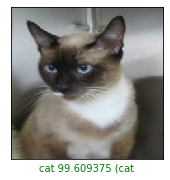

In [37]:
index = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [38]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

### Prepare the TEst Images for Download

In [ ]:
from PIL import image

In [ ]:
for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save(f'test_images/{class_names[label[0]]}_{index}')

In [ ]:
!ls test_images

In [ ]:
!zip -qq cats_vs_dogs_test_images.zip -r test_images/